<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-предобработка-данных" data-toc-modified-id="Загрузка-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и предобработка данных</a></span></li><li><span><a href="#Подготовка-функций" data-toc-modified-id="Подготовка-функций-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка функций</a></span></li><li><span><a href="#Расчет-статистических-данных" data-toc-modified-id="Расчет-статистических-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчет статистических данных</a></span></li><li><span><a href="#Расчет-10-самых-частых-слов" data-toc-modified-id="Расчет-10-самых-частых-слов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчет 10 самых частых слов</a></span></li><li><span><a href="#Формирование-сообщения-с-отчетом" data-toc-modified-id="Формирование-сообщения-с-отчетом-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Формирование сообщения с отчетом</a></span></li></ul></div>

# Статистика чата в Telegram

Видя большую активность в чате своей учебной когорты в Telegram, я решил написать скрипт, который каждый день составляет статистику по следующим показателям:
- количество сообщений и относительная разница с предыдущим днем;
- количество общавшихся людей и разница с предыдущим днем;
- среднее число символов и слов в сообщениях за день;
- топ-10 самых часто используемых слов;
- топ-5 самых разговорчивых людей;
- автор самого длинного сообщения;
- топ-3 самых любознательных;
- топ-3 самых благодарных;
- топ-3 матершинников;
- топ-5 самых неразговорчивых.

В качестве базы данных используются ежедневные выгрузки из чата в формате json.

ПС. Вырезал все фрагменты, которые могли бы идентифицировать участников группы.

## Загрузка и предобработка данных 

In [1]:
# !pip install emoji
# !pip install pymorphy2
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta, date
import datetime as dt
import re
import emoji
import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
pd.options.display.max_colwidth = 150
pd.set_option('chained_assignment', None)

Считываем выгруженный из чата json-файл и конвертируем его в датафрейм. Файл имеет название типа 'ChatExport_2022-09-03'.

In [3]:
with open(f'C:/.../ChatExport_{str(date.today())}/result.json',
          encoding = 'UTF-8') as file:
    data = json.load(file)

print(f'''Название чата — "{data['name']}"''')

Название чата — "комната без света"


In [4]:
messages = pd.json_normalize(data,
                                record_path='messages',
                                meta='id',
                                record_prefix='messages-',
                                errors="ignore")

Избавляемся от форвардов, системных сообщений и сообщений от бота.

In [5]:
messages = messages[messages['messages-type'] == 'message']
messages = messages[messages['messages-from_id'] != 'user752259676']
messages = messages[messages['messages-forwarded_from'].isna()]

In [6]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1700 entries, 0 to 1715
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   messages-id                   1700 non-null   int64  
 1   messages-type                 1700 non-null   object 
 2   messages-date                 1700 non-null   object 
 3   messages-date_unixtime        1700 non-null   object 
 4   messages-edited               417 non-null    object 
 5   messages-edited_unixtime      417 non-null    object 
 6   messages-from                 1700 non-null   object 
 7   messages-from_id              1700 non-null   object 
 8   messages-photo                109 non-null    object 
 9   messages-width                152 non-null    float64
 10  messages-height               152 non-null    float64
 11  messages-text                 1700 non-null   object 
 12  messages-reply_to_message_id  871 non-null    float64
 13  mes

Оставим только нужные столбцы и приведем столбец со временем публикации поста к формату date.

In [ ]:
messages = messages[['messages-date', 'messages-from', 'messages-from_id', 'messages-text']]
messages['messages-date'] = pd.to_datetime(messages['messages-date'], format='%Y-%m-%d')
messages['messages-date'] = messages['messages-date'].apply(lambda x: dt.date(x.year,x.month,x.day))
messages.sample(10)

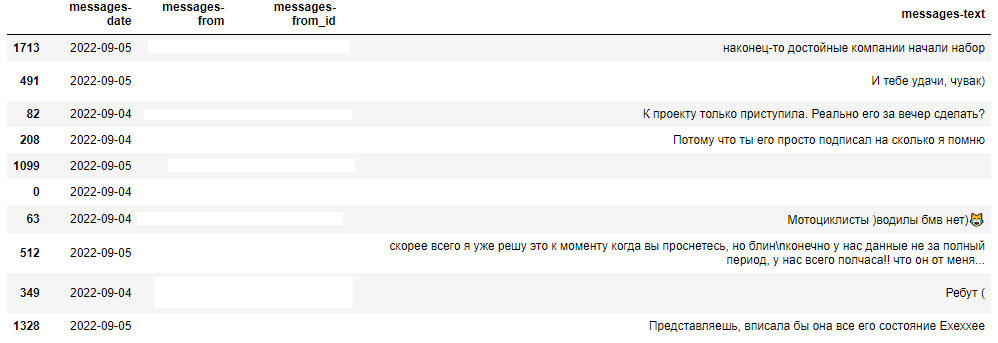

Отфильтруем сообщения по дате: вчера и позавчера.

In [11]:
yest = date.today() - timedelta(days=1)
two_days_ago = date.today() - timedelta(days=2)
yest_fmt = yest.strftime(format = '%d-%m-%Y')

In [ ]:
messages_yest = messages[messages['messages-date'] == yest]
messages_yest

In [ ]:
messages_2_days_ago = messages[messages['messages-date'] == two_days_ago]
messages_2_days_ago

Создадим список с юзернеймами всех участников группы, чтобы подставить их в итоговом сообщении.

In [14]:
username_dict = {
                'user391639940': '@Tiny_Ton', ...
                }

## Подготовка функций

Для нахождения сообщений с благодарностью.

In [15]:
def top_thankful(row):
    regex = r'пасиб|спс|thank|благодар(?=ю|им|ен|на)'
    if re.findall(regex, str(row), flags = re.IGNORECASE):
        result = 1
    else:
        result = 0
    return result

Для нахождения сообщений с вопросами.

In [16]:
def top_inquisitive(row):
    regex = r'(?<=[ \w])\?\B'
    if re.findall(regex, str(row)):
        result = 1
    else:
        result = 0
    return result

Для нахождения сообщений с матом.

In [17]:
def top_swearers(row):
    regex = r'\b(?:(?:а|сни|о|ни ?)?[хзкб]у[ й#*@]?(?:ца|е|е[вцн]|ю|ет[уаь]|н[яюе]|ел|л[ие]\b|я(?: [тс]ебе)?| [твн]ам| [тс]ебе))(?!ть)|(?:пи?[з\*][дж](?:ец|а|и[тш]ь?|у|ю|или?|е|ов|ят|ища))|(?<![лрт])(?:е[б\*]а[нл](?:ат[а|ом|ами]?|ько|))|(?<![вдрнч])(?:е[б\*](?:[уеа]т[ь]?|у(?:ч|чк.)?\b|цч|и|(?: тв| ва|ы)))|\b(?:на)?[хз]уй|(?:сук(?:[аи]|ой|аэл(?:ь|ем?)(?:чик)?|ами?)?)\b|(?<![рау])(?:ука)?(?:бл[яэ][тд]?(?:ью?|я*|ей|ями?)?)(?!н)|(?<!у)(?:муда?[^р ])|н[еи] ип(?:[уе]т?)'
    findall = re.findall(regex, str(row), flags = re.IGNORECASE)
    if findall:
        result = len(findall)
    else:
        result = 0
    return result

Для подсчета длины сообщений (очищаем от эмоджи и разбиваем на слова).

In [18]:
def words(row):
    deEmoj = emoji.demojize(str(row))
    regex = r":[a-z_]*:|{?'type'(?:\: ?)*|{?'code'(?:\: ?)*|{?'text'(?:\: ?)*|'|{|}"
    clean_text = re.sub(regex, '', deEmoj)
    strip = clean_text.strip()
    regex = r'\b[а-яё-]+\b'
    words_count = re.findall(regex, strip, flags = re.IGNORECASE)
    return len(words_count)

Применяем все функции.

In [ ]:
# подставляем юзернеймы
messages_yest['username'] = messages_yest['messages-from_id'].apply(lambda x: username_dict.get(x, '--'))
messages_yest['thanks'] = messages_yest['messages-text'].apply(top_thankful)
messages_yest['questions'] = messages_yest['messages-text'].apply(top_inquisitive)
messages_yest['swearer'] = messages_yest['messages-text'].apply(top_swearers)
# считаем длину сообщения в символах
messages_yest['symbols'] = messages_yest['messages-text'].apply(lambda x: len(str(x)))
messages_yest['words'] = messages_yest['messages-text'].apply(words)
messages_yest.sample(5)

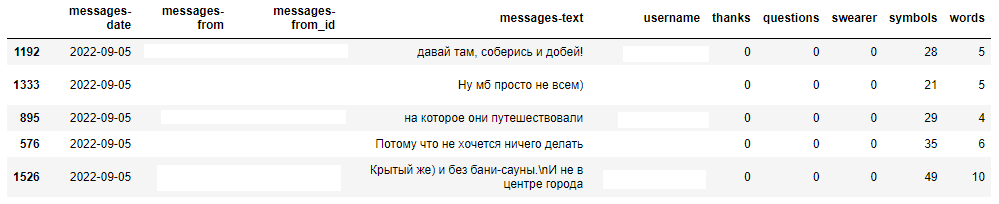

## Расчет статистических данных

Топ самых разговорчивых участников.

In [ ]:
msgs_grp = (
             messages_yest.groupby(['messages-from', 'messages-from_id', 'username'])
             ['messages-text'].count().sort_values(ascending=False).reset_index().head(10)
           )
msgs_grp

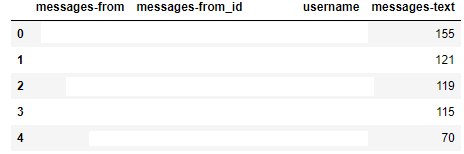

Топ самых благодарных.

In [ ]:
thanks_grp = (
               messages_yest[messages_yest['thanks'] == 1]
              .groupby(['messages-from', 'messages-from_id', 'username'])['thanks']
              .count().sort_values(ascending=False).reset_index().head(5)
             )
thanks_grp

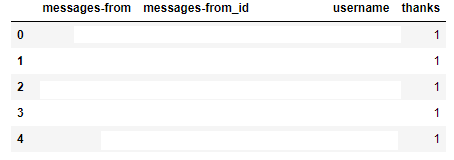

Топ самых любознательных.

In [ ]:
questions_grp = (
                  messages_yest[messages_yest['questions'] == 1]
                 .groupby(['messages-from', 'messages-from_id', 'username'])['questions']
                 .count().sort_values(ascending=False).reset_index().head(3)
                )
questions_grp

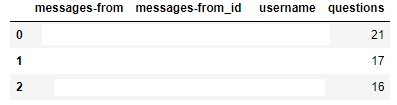

Топ самых молчаливых из тех, кто отправил хотя бы одно сообщение.

In [ ]:
most_reticent = (
                 messages_yest.groupby(['messages-from', 'messages-from_id', 'username'])
                 ['messages-text'].count().sort_values().reset_index().head(5)
                )
most_reticent

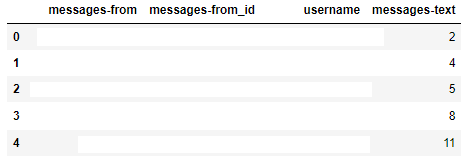

Топ матершинников.

In [ ]:
swearers_grp = (
               messages_yest[messages_yest['swearer'] == 1]
              .groupby(['messages-from', 'messages-from_id', 'username'])['swearer']
              .count().sort_values(ascending=False).reset_index().head(5)
             )
swearers_grp

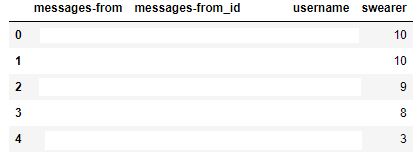

Нахождение самого длинного сообщения.

In [ ]:
longest_post = (
                messages_yest[['messages-from', 'messages-from_id', 'username', 'words']]
                .sort_values(by='words', ascending=False).head(3)
               )
longest_post

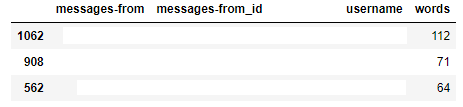

Расчет разницы в количестве общавшихся за два дня.

In [27]:
unique_yest = messages_yest['messages-from'].unique()
unique_2_days_ago = messages_2_days_ago['messages-from'].unique()
diff_chatting = len(unique_yest) - len(unique_2_days_ago)
diff_chatting

-1

Расчет относительной разницы в количестве сообщений за два дня.

In [28]:
diff = round((len(messages_yest) - len(messages_2_days_ago)) / len(messages_2_days_ago) * 100, 1)
print(f'Изменение: {diff}%')

Изменение: 154.9%


Расчет медианной длины сообщения в словах. 

In [29]:
mdn_words = int(messages_yest['words'].median())
mdn_words

5

Расчет медианной длины сообщения в символах.

In [30]:
mdn_symbols = int(messages_yest['symbols'].median())
mdn_symbols

28

Определение формулировок для итогового сообщения.

In [31]:
if diff_chatting == 0:
    chatting = 'столько же, сколько и днем ранее'
elif diff_chatting > 0:
    chatting = f'на {diff_chatting} больше, чем днем ранее'
else:
    chatting = f'на {abs(diff_chatting)} меньше, чем днем ранее'

In [32]:
if len(unique_yest) % 10 in (2, 3, 4):
    people = 'человека'
else:
    people = 'человек'

In [33]:
if longest_post.iloc[0][3] % 100 in (11, 12, 13, 14):
    wordform = 'слов'
else:
    if longest_post.iloc[0][3] % 10 == 1:
        wordform = 'слово'
    elif longest_post.iloc[0][3] % 10 in (2, 3 ,4):
        wordform = 'слова'   
    else:
        wordform = 'слов'

In [34]:
if diff < 0:
    msgs = 'меньше'
else:
    msgs = 'больше'

## Расчет 10 самых частых слов

Функция для очищения текста от эмоджи и знаков препинания. 

In [36]:
def full_clean_text(row):
    deEmoj = emoji.demojize(str(row))
    regex = r"""[—'{}\\:;,.()\[\]a-z@\/?\+!0-9&_=#$%^*~\"…«»-]+|\n"""
    clean_text = re.sub(regex, ' ', deEmoj, flags = re.IGNORECASE)
    return clean_text

Лемматизация слов.

In [ ]:
messages_yest_wo_me = messages_yest.copy()
messages_yest_wo_me['clean_text'] = messages_yest_wo_me['messages-text'].apply(full_clean_text)
morph = MorphAnalyzer()
clean_text = []
for message in messages_yest_wo_me['clean_text']:
    token = list(map(lambda x: morph.normal_forms(x.strip())[0], message.lower().split()))
    clean_text.extend(token)

clean_text = ' '.join(clean_text)
clean_text = clean_text.replace('ё', 'е')
clean_text

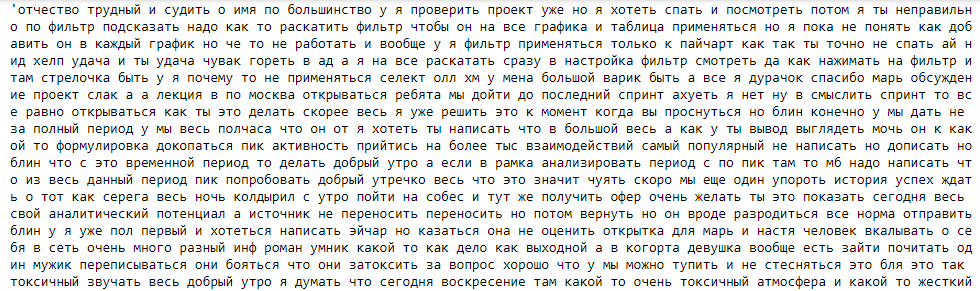

In [38]:
text_tokens = word_tokenize(clean_text)
text_tokens = nltk.Text(text_tokens)

Исключение из топа стоп-слов, не несущих смысл для понимания тематики общения в чате.

In [39]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это', 'еще', 'очень', 'вообще', 'просто', 'кстати', 'вроде',
                          'хз', 'тебе', 'ок', 'пока', 'типа', 'какие', 'кажется',
                          'сегодня', 'завтра', 'поэтому', 'такой', 'вчера', 'норм',
                          'спасибо', 'блин', 'ага', 'ща', 'прям', 'который', 'весь',
                          'свой', 'тип', 'мой', 'твой', 'наш', 'ваш', 'самый', 'ой'])

In [40]:
words_frequency_wo_sw = [word for word in text_tokens if not word in russian_stopwords]
words_frequency_wo_sw = FreqDist(words_frequency_wo_sw)
top_10_words = words_frequency_wo_sw.most_common(10)

In [41]:
top_10_words

[('работа', 31),
 ('мочь', 29),
 ('хотеть', 26),
 ('написать', 23),
 ('работать', 22),
 ('спринт', 22),
 ('день', 22),
 ('делать', 21),
 ('думать', 19),
 ('говорить', 19)]

In [42]:
top_10_words_str = ''
for i in range(len(top_10_words)):
    top_10_words_str += top_10_words[i][0] + ', '
top_10_words_str[:-2]

'работа, мочь, хотеть, написать, работать, спринт, день, делать, думать, говорить'

## Формирование сообщения с отчетом

In [ ]:
print(f"""❗️❗️❗️

**"{data['name']}"**

Статистика чата за вчера ({yest_fmt}).
   
Оставлено сообщений: {len(messages_yest)},
что **на {abs(diff)}% {msgs}**, чем днем ранее.

Всего общались: **{len(unique_yest)} {people}**
({chatting}).

**Медианная длина** сообщения:
слов — {mdn_words}, символов — {mdn_symbols}

Топ-10 **самых частых** слов:
{top_10_words_str[:-2]}

__Самые разговорчивые в чате__:
1) **{msgs_grp.iloc[0][0]}** ({msgs_grp.iloc[0][2]}) (сообщений: {msgs_grp.iloc[0][3]}) 🥇
2) **{msgs_grp.iloc[1][0]}** ({msgs_grp.iloc[1][2]}) (сообщений: {msgs_grp.iloc[1][3]}) 🥈
3) **{msgs_grp.iloc[2][0]}** ({msgs_grp.iloc[2][2]}) (сообщений: {msgs_grp.iloc[2][3]}) 🥉
4) **{msgs_grp.iloc[3][0]}** ({msgs_grp.iloc[3][2]}) (сообщений: {msgs_grp.iloc[3][3]})
5) **{msgs_grp.iloc[4][0]}** ({msgs_grp.iloc[4][2]}) (сообщений: {msgs_grp.iloc[4][3]})

__Самое длинное сообщение__:
**{longest_post.iloc[0][0]}** ({longest_post.iloc[0][2]}) ({longest_post.iloc[0][3]} {wordform})

__Самые любознательные__:""")

for i in range(3):
        print(f'{i+1}) **{questions_grp.iloc[i][0]}** ({questions_grp.iloc[i][2]}) (вопросов: {questions_grp.iloc[i][3]})')

print("""
__Самые благодарные__:""")

try:
    for i in range(3):
        print(f'{i+1}) **{thanks_grp.iloc[i][0]}** ({thanks_grp.iloc[i][2]}) (поблагодарил(а) раз: {thanks_grp.iloc[i][3]})')
except IndexError:
    pass

print("""
__Топ матершинников__:""")

if len(swearers_grp):
    try:
        for i in range(3):
            print(f'{i+1}) **{swearers_grp.iloc[i][0]}** ({swearers_grp.iloc[i][2]}) (выругался(-ась) раз: {swearers_grp.iloc[i][3]})')
    except IndexError:
        pass
else:
    print('Вчера никто не ругался! Дожили!')
    
print("""
__Самые неразговорчивые из общавшихся__:""")
for i in range(5):
    print(f'{i+1}) **{most_reticent.iloc[i][0]}** ({most_reticent.iloc[i][2]}) (сообщений: {most_reticent.iloc[i][3]})')

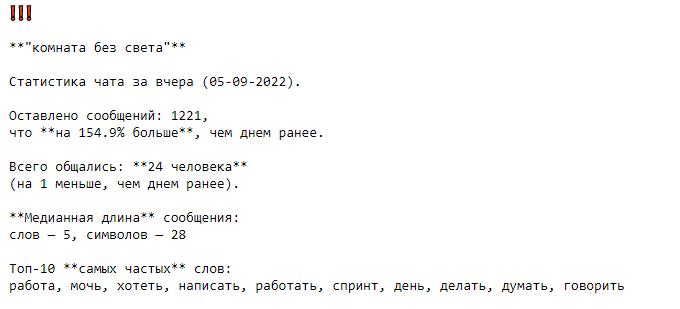

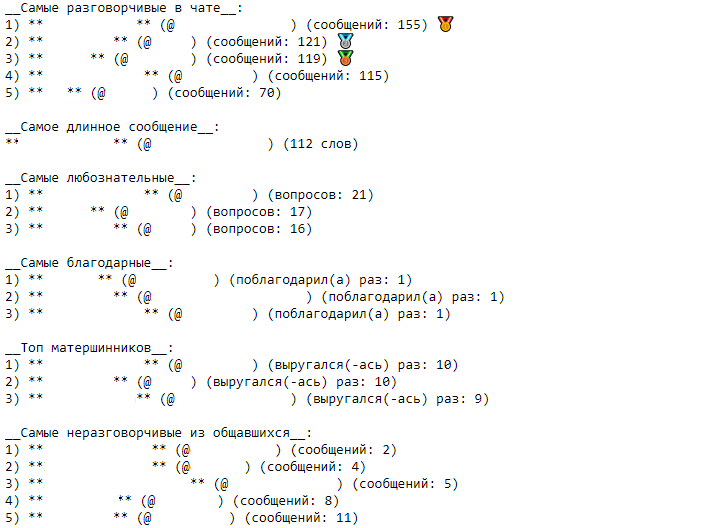

В телеграме сообщение выглядит вот так:
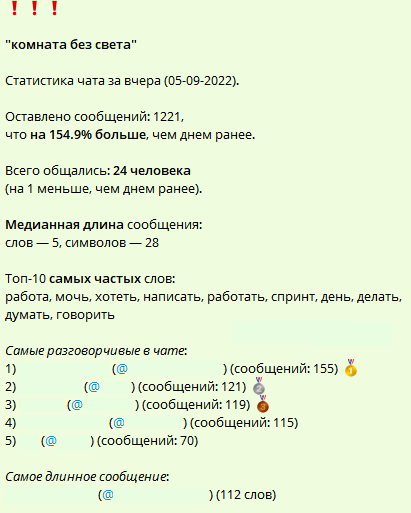